In [2]:
import tensorflow as tf

# turn off multithreading
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping

import sklearn



NameError: name 'MC_EXT' is not defined

In [12]:
import numpy as np
import uproot3
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import Neutrino_functions

from math import *
import scipy as sci
import scipy.optimize

# MACHINE LEARNING IMPORTS
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# import scaling stufff
from sklearn.preprocessing import StandardScaler


In [4]:
# MC
MC_file = './data/MC_EXT_flattened.pkl'

# Data
data_file = './data/data_flattened.pkl'


# Open file as pandas dataframe
MC_EXT = pd.read_pickle(MC_file)
data = pd.read_pickle(data_file)

# removing 'Subevent' from data
MC_EXT = MC_EXT.drop('Subevent', axis = 1)
data = data.drop('Subevent', axis = 1)

In [10]:

MC_EXT_ML_keras = MC_EXT.copy(deep = True)
MC_EXT_ML_keras = MC_EXT_ML_keras.drop(MC_EXT_ML_keras[MC_EXT_ML_keras.category == 21].index)
MC_EXT_ML_keras = MC_EXT_ML_keras.drop(MC_EXT_ML_keras[MC_EXT_ML_keras.category == 10].index)

# In here, set categories to 0,1,2,3
# 0 -> 4 (cosmic)
# 1 -> 5 (Out Fid. Vol.)
# 2 -> 7 (EXT)
# 3 -> 31 (mu CC)
MC_EXT_ML_keras.loc[MC_EXT_ML_keras['category'] == 4, 'category'] = 0
MC_EXT_ML_keras.loc[MC_EXT_ML_keras['category'] == 5, 'category'] = 1
MC_EXT_ML_keras.loc[MC_EXT_ML_keras['category'] == 7, 'category'] = 2
MC_EXT_ML_keras.loc[MC_EXT_ML_keras['category'] == 31, 'category'] = 3

MC_EXT_ML_keras.head(10)


,_closestNuCosmicDist,trk_len_v,trk_distance_v,category,topological_score,trk_sce_end_z_v,trk_sce_end_y_v,trk_sce_end_x_v,trk_score_v,trk_llr_pid_score_v,trk_sce_start_z_v,trk_sce_start_y_v,trk_sce_start_x_v,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,trk_energy_tot,weight
2,141.086923,251.017548,0.025229,1,0.007706,766.055969,-50.159794,172.77446,1.0,0.972468,658.480286,117.427391,20.797407,20.804905,117.408989,658.495789,9999.989363,0.158957
3,10.511966,58.736591,10.511966,0,0.066952,213.629105,117.414757,88.746597,0.929871,0.870984,224.018387,60.914005,78.242538,78.443840,50.530334,223.597870,9999.441230,0.192390
4,10.511966,9.962337,3.888895,0,0.066952,235.423004,46.921162,80.265305,0.372258,0.404711,226.829147,51.903919,80.192444,78.443840,50.530334,223.597870,9999.441230,0.192390
5,147.929810,289.265442,0.152002,1,0.515178,1031.704712,52.0289,83.527153,1.0,0.9848,761.951172,-6.10771,1.388844,1.357146,-6.141214,761.806335,9999.934871,0.986006
9,106.679589,73.540779,0.226748,1,0.040650,769.010193,110.767021,45.539276,0.950805,0.911611,759.31604,53.225922,1.124355,1.250130,53.412140,759.350220,9999.371950,0.194167
10,41.222479,114.836601,0.211092,1,0.765625,102.077225,16.744017,167.681717,0.999908,0.786889,1.092331,32.588955,217.273911,217.397171,32.586201,0.917827,9999.497628,0.193572
11,55.101011,97.195244,17.023422,1,0.000000,898.882812,-15.148562,205.327347,0.998706,0.773724,843.157227,-57.410507,190.6436,191.452545,-76.742142,843.320557,9999.777298,0.002082
12,55.101011,59.66201,34.282501,1,0.000000,873.753357,-96.354698,191.894272,0.89153,0.853727,814.257629,-97.996552,192.21138,191.452545,-76.742142,843.320557,9999.777298,0.002082
15,134.372686,87.078835,0.941204,0,0.044977,141.104431,120.174568,177.228149,0.976836,0.896398,138.412598,61.17004,240.953186,240.854385,61.678581,137.626022,9999.579481,0.180298
16,134.372686,7.960309,136.967194,0,0.044977,-2.536525,34.838459,252.187881,0.015243,0.09638,1.626588,30.760492,257.545776,240.854385,61.678581,137.626022,9999.579481,0.180298


In [13]:
features = ['_closestNuCosmicDist', 'trk_len_v', 'trk_distance_v', 'topological_score', 'trk_sce_end_z_v', 'trk_sce_end_y_v', 'trk_sce_end_x_v', 'trk_score_v', 'trk_llr_pid_score_v', 'trk_sce_start_z_v', 'trk_sce_start_y_v', 'trk_sce_start_x_v', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'trk_energy_tot']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(MC_EXT_ML_keras[features])

y = np.array(MC_EXT_ML_keras['category'])


# scaled, but same shape
print(scaled_data)
print(MC_EXT_ML_keras[features].shape, scaled_data.shape)

# now split for usage
xs_train, xs_test, ys_train, ys_test = train_test_split(scaled_data, y, test_size = 0.3, random_state = 1)

[[ 0.29032743  1.22551112 -0.32571788 ...  1.27954916  0.61152635
   0.37763205]
 [-1.16653145 -0.43923023 -0.198623   ...  0.43132276 -0.77055524
   0.37746616]
 [-1.16653145 -0.86151083 -0.27889186 ...  0.43132276 -0.77055524
   0.37746616]
 ...
 [ 0.1615978   0.22815674 -0.31940125 ...  0.46183234  0.10385286
   0.37754535]
 [ 0.1615978  -0.81540081 -0.31990405 ...  0.46183234  0.10385286
   0.37754535]
 [ 0.59696934 -0.42681703  3.09562344 ...  1.2870956  -1.36969251
   0.37748382]]
(319216, 16) (319216, 16)


In [14]:
# Create Keras Model
inpt = Input(shape=(xs_train.shape[1]))
layer0 = Dense(256, activation='relu')(inpt)
drop1 = Dropout(.4)(layer0)
layer1 = Dense(128, activation='relu')(drop1)
layer2 = Dense(64, activation='relu')(layer1)
drop2 = Dropout(.2)(layer2)
layer3 = Dense(32, activation='relu')(drop2)
layer4 = Dense(16, activation='relu')(layer3)
output = Dense(4, activation='softmax')(layer3)

kf = Model(inputs=inpt, outputs=output, name='kerasNN')

In [15]:
# Compile using Adam optimiser
kf.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Get summary of NN
kf.summary()

Model: "kerasNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080

In [16]:
# callback to stop it running forever
callbacks = EarlyStopping(monitor = 'val_loss', patience = 4, min_delta = 0.001, verbose = 1)
# train network
kff = kf.fit(xs_train, ys_train, epochs = 25, batch_size = 32, validation_data = (xs_test, ys_test), callbacks = callbacks)

Epoch 1/25
6983/6983 [==============================] - 12s 2ms/step - loss: 0.9596 - accuracy: 0.6084 - val_loss: 0.9029 - val_accuracy: 0.6349
Epoch 2/25
6983/6983 [==============================] - 12s 2ms/step - loss: 0.9111 - accuracy: 0.6308 - val_loss: 0.8728 - val_accuracy: 0.6470
Epoch 3/25
6983/6983 [==============================] - 12s 2ms/step - loss: 0.8895 - accuracy: 0.6411 - val_loss: 0.8670 - val_accuracy: 0.6502
Epoch 4/25
6983/6983 [==============================] - 12s 2ms/step - loss: 0.8783 - accuracy: 0.6465 - val_loss: 0.8530 - val_accuracy: 0.6563
Epoch 5/25
6983/6983 [==============================] - 11s 2ms/step - loss: 0.8716 - accuracy: 0.6490 - val_loss: 0.8496 - val_accuracy: 0.6578
Epoch 6/25
6983/6983 [==============================] - 11s 2ms/step - loss: 0.8656 - accuracy: 0.6514 - val_loss: 0.8429 - val_accuracy: 0.6595
Epoch 7/25
6983/6983 [==============================] - 10s 1ms/step - loss: 0.8611 - accuracy: 0.6533 - val_loss: 0.8396 - val_ac

In [17]:
# evaluate
print("KERAS ACCURACY AND LOSS \n")

print("Test data accuracy and loss")
stest_res = kf.evaluate(xs_test, ys_test)
print("\n")

print("Training data accuracy and loss")
strain_res = kf.evaluate(xs_train, ys_train)


KERAS ACCURACY AND LOSS 

Test data accuracy and loss
2993/2993 [==============================] - 2s 697us/step - loss: 0.8130 - accuracy: 0.6720


Training data accuracy and loss
6983/6983 [==============================] - 5s 696us/step - loss: 0.7990 - accuracy: 0.6787


In [18]:
# create confusion matrix
test_pred = kf.predict(xs_test)
y_pred1 = np.argmax(test_pred, axis=1)

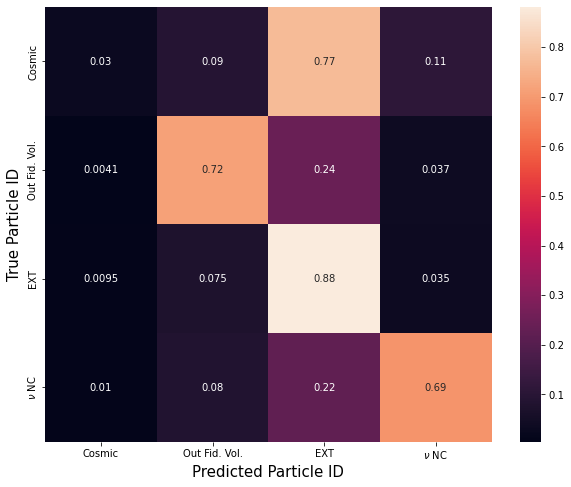

In [20]:
ptype_no_mu_e = [r"Cosmic", r"Out Fid. Vol.", r"EXT", r"$\nu$ NC"]

matrix = confusion_matrix(ys_test, y_pred1, normalize = 'true')
df_cm = pd.DataFrame(matrix, index = ptype_no_mu_e, columns = ptype_no_mu_e)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Particle ID', fontsize = 15)
plt.ylabel('True Particle ID', fontsize = 15)
plt.show()


In [21]:
# save model
kf.save('example_NN_model.h5')